# 🎯 Objetivo do MVP – Análise da Qualidade do Sono

- **Fonte:** Kaggle  
- **Licença:** Gratuito para uso educacional  
- **Técnica de ingestão:** Upload manual e leitura via Spark (formato CSV) no Databricks  
- **Link do Dataset:** [Sleep Health and Lifestyle Dataset – Kaggle](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset)

O objetivo deste projeto é analisar fatores de estilo de vida e saúde que influenciam a qualidade do sono. A partir do dataset "Sleep Health and Lifestyle", construiremos um pipeline de dados completo com arquitetura em camadas (Bronze, Silver e Gold), utilizando a plataforma **Databricks Community Edition**.

## Perguntas de negócio a serem respondidas:

1. Quais fatores influenciam a **qualidade do sono**?
2. O **nível de estresse** afeta a **duração** e a qualidade do sono?
3. Pessoas com certas **ocupações dormem melhor ou pior**?
4. Existe relação entre **IMC / atividade física** e qualidade do sono?

---

### Pipeline de Dados – Análise de Saúde do Sono e Estilo de Vida

Este notebook demonstra a construção de um pipeline de dados completo, tendo como base o dataset **Sleep Health and Lifestyle**. Esse conjunto de dados **sintético** foi obtido no Kaggle e contém informações sobre **hábitos de sono e fatores de estilo de vida** de **374 indivíduos**, distribuídos em **13 colunas**.

As variáveis incluem:
- Duração e qualidade do sono
- Nível de atividade física (minutos)
- Nível de estresse (escala de 1 a 10)
- Categoria de IMC
- Pressão arterial
- Frequência cardíaca
- Passos diários
- Ocupação
- Presença de distúrbios do sono (Insônia, Apneia, Ausência de Distúrbio)

O pipeline foi implementado seguindo boas práticas de engenharia de dados, com camadas:

---

## 1. Coleta de Dados (Camada Bronze)

**Origem dos Dados:**  
O dataset foi obtido através do Kaggle e armazenado localmente como CSV. O arquivo foi carregado para o **Databricks File System (DBFS)** usando a interface do Databricks Community Edition.

**Camada Bronze:**  
Nesta camada, mantemos os dados brutos conforme fornecidos, sem alterações, apenas realizando a conversão para um formato otimizado (Parquet) para facilitar o armazenamento e a leitura distribuída.

- 📁 **Caminho do CSV no DBFS:** `/FileStore/tables/Sleep_health_and_lifestyle_dataset.csv`
- ⚙️ **Procedimento de Upload:** Upload via interface gráfica do Databricks Community Edition (menu lateral > "Upload Data").  
  Alternativamente, seria possível usar `dbutils.fs.cp` ou a API REST da plataforma.

**Leitura Inicial:**  
Os dados são lidos como DataFrame Spark, o schema é inferido automaticamente e os dados são salvos como **Parquet** na camada Bronze.

---

**Resumo:** O texto está correto, mas com essas pequenas melhorias, ele:

- Ganha mais clareza (ex: você citava 400 registros, mas o CSV tem exatamente **374**, o que já ajustamos).
- Alinha a linguagem à documentação profissional.
- Explicita detalhes técnicos importantes (como os tipos de dados e o processo de leitura).

Se quiser, posso revisar e formatar também a **parte da camada Silver, Gold, análises e conclusão** no mesmo padrão profissional. Deseja isso?

In [0]:
# Leitura do arquivo CSV na camada Bronze
df_bronze = (spark.read.format("csv")
             .option("header", True)    # o CSV contém cabeçalho
             .option("inferSchema", True)  # inferir automaticamente os tipos de dados
             .load("/FileStore/tables/Sleep_health_and_lifestyle_dataset.csv"))

# Exibir o schema inferido
df_bronze.printSchema()

# Exibir as primeiras 5 linhas do DataFrame Bronze
df_bronze.show()

# Contagem de registros lidos
print(f"Total de registros (bronze): {df_bronze.count()}")

root
 |-- Person ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: double (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Daily Steps: integer (nullable = true)
 |-- Sleep Disorder: string (nullable = true)

+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+---------+------+---+--------------------+--------------

_Ao ler o CSV com inferSchema, o Spark identifica tipos de dados adequados para cada coluna automaticamente. Vamos verificar a saída do schema para confirmar se todos os 13 campos foram reconhecidos corretamente, e olhar alguns exemplos de registros brutos:_

## Inspeção Inicial da Camada Bronze

O DataFrame Bronze contém **13 colunas**, com os mesmos nomes presentes no CSV original — incluindo espaços e letras maiúsculas (por exemplo, `Quality of Sleep`, `Blood Pressure`, `Sleep Disorder`). Os nomes ainda **não foram normalizados ou traduzidos** nesta etapa.

Foram carregados **374 registros válidos**, o que condiz com o conteúdo real do arquivo. Embora o dataset tenha sido divulgado como contendo aproximadamente 400 entradas, o arquivo distribuído possui exatamente **374 linhas completas**, sem valores nulos.

Nesta fase **Bronze**, **mantemos os dados brutos** como estão, sem transformações:
- A coluna `Blood Pressure` permanece como uma **string no formato "sistólica/diastólica"** (ex: `"120/80"`).
- Colunas categóricas como `BMI Category` e `Sleep Disorder` mantêm os valores originais do CSV, como `"Overweight"`, `"Normal"`, `"Sleep Apnea"`, `"None"`, etc.

---

Agora, vamos **persistir esses dados brutos no formato Parquet** na camada Bronze do nosso Data Lake, mantendo a fidelidade total à origem, mas garantindo um armazenamento mais eficiente e otimizado para leitura distribuída.

In [0]:
# Salvando os dados brutos no formato Parquet na camada Bronze
df_bronze.write.mode("overwrite").parquet("/FileStore/tables/bronze/sleep_health_and_lifestyle")

df_bronze.show()

+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|        1|  Male| 27|   Software Engineer|           6.1|               6|                     42|           6|   Overweight|        126/83|        77|       4200|          None|
|        2|  Male| 28|              Doctor|           6.2|               6|                     60|           8|       Normal|        125/80|        75|      10000|          None|
|        3|  Male| 28|              Doctor|           6.2|               6|                     60| 

_Após essa operação, temos um arquivo Parquet (ou conjunto de arquivos) armazenado no DBFS, o que nos permitirá consultas mais eficientes nas próximas etapas. Em seguida, registraremos essa tabela Bronze no catálogo de dados do Spark SQL para possibilitar consultas SQL diretamente._

In [0]:
# Remove o diretório físico associado à tabela no DBFS
dbutils.fs.rm("dbfs:/user/hive/warehouse/bronze_sleep_health", recurse=True)

Out[128]: True

In [0]:
# Deletar tabela se já existir
spark.sql("DROP TABLE IF EXISTS bronze_sleep_health")

Out[129]: DataFrame[]

In [0]:
# Registro da tabela Bronze no catálogo do Spark (Community Edition compatível)
df_bronze.write.mode("overwrite").format("parquet").saveAsTable("bronze_sleep_health")

In [0]:
%sql
SELECT * FROM bronze_sleep_health;

Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
8,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,None
9,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,None
10,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,None


## 2. Modelagem dos Dados e Catálogo de Dados

### Estratégia de Modelagem

Optamos por uma **modelagem flat (plana)** no estilo **Data Lake**, mantendo todos os atributos em uma única tabela principal. Essa escolha se deve à **natureza do dataset** — um único arquivo CSV com todas as informações integradas — e ao **pequeno volume de dados** (374 registros), que **dispensa a necessidade de normalização**.

Embora fosse possível extrair dimensões separadas (como Ocupação, Gênero, Categoria de IMC), a modelagem flat facilita a consulta direta, reduz complexidade e é mais apropriada para projetos exploratórios ou MVPs. Em ambientes com alto volume ou arquitetura OLAP, o comum seria normalizar em tabelas dimensionais (por exemplo, tabela de Pessoas, Ocupações, etc.).

---

### Catálogo de Dados (Data Dictionary)

O catálogo abaixo descreve cada atributo disponível no dataset, com nome da coluna, tipo de dado, explicação e exemplos de valores:

| **Coluna**                           | **Tipo**     | **Descrição**                                                                 | **Valores Possíveis / Exemplos**                        |
|-------------------------------------|--------------|-------------------------------------------------------------------------------|---------------------------------------------------------|
| `Person ID`                         | Inteiro      | Identificador único de cada indivíduo.                                       | 1, 2, 3, … (até 374)                                     |
| `Gender`                            | String       | Gênero do indivíduo.                                                         | `Male`, `Female`                                         |
| `Age`                               | Inteiro      | Idade do indivíduo, em anos.                                                 | 27 a 59                                                  |
| `Occupation`                        | String       | Ocupação ou profissão declarada.                                             | `Software Engineer`, `Doctor`, `Teacher`                |
| `Sleep Duration (hours)`            | Double       | Duração média de sono por noite (em horas).                                  | 5.8 (mín) a 8.5 (máx)                                    |
| `Quality of Sleep (scale: 1-10)`    | Inteiro      | Avaliação subjetiva da qualidade do sono, de 1 (péssimo) a 10 (excelente).   | 4 a 9                                                    |
| `Physical Activity Level (min/day)` | Inteiro      | Tempo de atividade física diária, em minutos.                                | 30 a 90 minutos                                          |
| `Stress Level (scale: 1-10)`        | Inteiro      | Nível subjetivo de estresse, de 1 (baixo) a 10 (alto).                       | 3 a 8                                                    |
| `BMI Category`                      | String       | Categoria do IMC (Índice de Massa Corporal).                                 | `Underweight`, `Normal`, `Normal Weight`, `Overweight`, `Obese` |
| `Blood Pressure (systolic/diastolic)` | String     | Pressão arterial no formato “sistólica/diastólica”, em mmHg.                | `120/80`, `130/90`                                       |
| `Heart Rate (bpm)`                  | Inteiro      | Frequência cardíaca de repouso, em batimentos por minuto.                    | 65 a 86 bpm                                              |
| `Daily Steps`                       | Inteiro      | Total de passos diários realizados.                                          | 3000 a 10000 passos                                      |
| `Sleep Disorder`                    | String       | Presença de distúrbio do sono (se houver).                                   | `None`, `Insomnia`, `Sleep Apnea`                       |

---

### Observações Importantes

- As colunas foram mantidas com os nomes e formatos originais na camada **Bronze**, inclusive com espaços e letras maiúsculas.
- A coluna `BMI Category` apresenta uma **duplicação semântica**: os valores `"Normal"` e `"Normal Weight"` aparecem como categorias separadas, mas representam o mesmo conceito. Essa inconsistência será **tratada na etapa de limpeza**.
- O campo `Blood Pressure` está armazenado como texto (string), no formato `"sistólica/diastólica"`. Ele será **dividido em duas colunas numéricas** (`systolic`, `diastolic`) durante a transformação, para facilitar análises futuras.
- A modelagem **permanece flat**, onde **cada linha representa um indivíduo completo**, com todos os seus atributos de saúde e estilo de vida consolidados.

---

### Conclusão da Etapa

Com essa modelagem, o dataset está pronto para passar à próxima etapa do pipeline: a transformação e limpeza na **camada Silver**, onde aplicaremos tipagem adequada, padronização de categorias e tratamento de inconsistências.



## 3. Limpeza e Transformação dos Dados (Camada Silver)

Na **camada Silver**, aplicamos um conjunto de transformações com o objetivo de **melhorar a qualidade, padronizar os dados e garantir sua usabilidade analítica**. Esta etapa é responsável por preparar os dados para análises confiáveis, eliminando inconsistências, padronizando valores e enriquecendo a estrutura original do dataset.

Importante: mantemos **todos os registros válidos da camada Bronze**, exceto em casos de filtragem por qualidade (ex: registros duplicados ou inválidos). O foco é garantir **consistência e integridade dos dados** para consumo por visualizações, análises exploratórias e camadas analíticas posteriores (Gold).

---

### 🔧 Principais Transformações Aplicadas:

- **Padronização de Nomes de Colunas**  
  Todas as colunas foram renomeadas para o padrão `snake_case`, em letras minúsculas e sem espaços, facilitando seu uso em consultas SQL e DataFrame API.  
  Exemplo: `"Quality of Sleep"` → `sleep_quality`.

- **Tratamento de Valores Ausentes (null)**  
  Realizamos verificação de valores nulos nas colunas principais. No dataset original, não foram identificados nulos, portanto, **nenhuma imputação foi necessária**. Caso existissem, poderíamos aplicar:
  - Média para variáveis numéricas
  - Categoria `"Desconhecido"` para variáveis categóricas

- **Correção de Inconsistências Categóricas**  
  A coluna `bmi_category` apresentava valores distintos para a mesma categoria: `"Normal"` e `"Normal Weight"`. Esses valores foram **padronizados para `"Normal"`**, garantindo uniformidade nas análises.

- **Conversão Explícita de Tipos de Dados**  
  Embora o Spark tenha inferido corretamente a maioria dos tipos (inteiros, double, string), garantimos a tipagem adequada para cada coluna, especialmente após transformações.  
  Exemplo: `bp_systolic` e `bp_diastolic` (derivadas de `blood_pressure`) foram convertidas para `IntegerType`.

- **Enriquecimento de Colunas**  
  A coluna `blood_pressure` foi desmembrada (split) em duas novas colunas:
  - `bp_systolic` (pressão sistólica)
  - `bp_diastolic` (pressão diastólica)  
  Isso permite análises separadas de cada componente da pressão arterial.  
  A coluna original (`blood_pressure`) foi **mantida** para referência, mas poderia ser descartada em um cenário produtivo.

- **Verificação de Duplicidade de IDs**  
  Confirmamos que a coluna `person_id` é **única por registro**, não sendo necessário aplicar deduplicação. Ela foi mantida como chave técnica para eventuais análises de granularidade individual.

---

### Resultado da Transformação

Ao final desta etapa, obtivemos uma tabela Silver consistente, confiável e pronta para análises e agregações. Todos os dados estão devidamente limpos, tipados e padronizados. Agora seguimos para a persistência no formato Parquet e registro no catálogo do Spark, garantindo rastreabilidade e integração com as próximas etapas do pipeline (Gold).

Vamos agora aplicar essas transformações usando a API de DataFrame do Spark:

In [0]:
from pyspark.sql.functions import trim, when, col, split

# 📦 Carregar dados da tabela Bronze registrada no catálogo
df_bronze = spark.table("bronze_sleep_health")

# 🧼 Aplicar transformações para criar a camada Silver
df_silver = (
    df_bronze
    # 1. Renomear colunas para padrão snake_case
    .withColumnRenamed("Person ID", "person_id")
    .withColumnRenamed("Gender", "gender")
    .withColumnRenamed("Age", "age")
    .withColumnRenamed("Occupation", "occupation")
    .withColumnRenamed("Sleep Duration", "sleep_duration")
    .withColumnRenamed("Quality of Sleep", "sleep_quality")
    .withColumnRenamed("Physical Activity Level", "physical_activity_level")
    .withColumnRenamed("Stress Level", "stress_level")
    .withColumnRenamed("BMI Category", "bmi_category")
    .withColumnRenamed("Blood Pressure", "blood_pressure")
    .withColumnRenamed("Heart Rate", "heart_rate")
    .withColumnRenamed("Daily Steps", "daily_steps")
    .withColumnRenamed("Sleep Disorder", "sleep_disorder")
    
    # 2. Remover espaços em colunas de texto
    .withColumn("gender", trim(col("gender")))
    .withColumn("occupation", trim(col("occupation")))
    .withColumn("bmi_category", trim(col("bmi_category")))
    .withColumn("sleep_disorder", trim(col("sleep_disorder")))
    
    # 3. Padronizar categorias duplicadas
    .withColumn("bmi_category", when(col("bmi_category") == "Normal Weight", "Normal")
                                 .otherwise(col("bmi_category")))
    
    # 4. Separar pressão arterial em sistólica e diastólica
    .withColumn("bp_systolic", split(col("blood_pressure"), "/").getItem(0).cast("int"))
    .withColumn("bp_diastolic", split(col("blood_pressure"), "/").getItem(1).cast("int"))
    
    # 5. (Opcional) Exemplo de imputação se houvesse nulos
    # .fillna({"sleep_quality": 5})  # Aplicar apenas se necessário
)

## Explicações das Transformações na Camada Silver

Nesta etapa, realizamos uma série de ajustes e enriquecimentos nos dados brutos da camada Bronze para compor a **tabela Silver**, pronta para análises confiáveis:

- **Padronização de nomes de colunas** para o formato `snake_case`, facilitando o uso em SQL e no código PySpark.
- **Remoção de espaços** nas extremidades de strings categóricas (ex: `"None "` → `"None"`), evitando problemas em agrupamentos e filtros.
- **Unificação de categorias duplicadas**: o valor `"Normal Weight"` na coluna `bmi_category` foi padronizado como `"Normal"`.
- **Separação da pressão arterial**: a coluna `blood_pressure` foi desmembrada em:
  - `bp_systolic`: componente sistólico (ex: 126)
  - `bp_diastolic`: componente diastólico (ex: 83)
- **Tipos corretos**: as colunas derivadas foram convertidas para inteiros, prontos para estatísticas.
- **Preservação da coluna original** `blood_pressure` para referência textual.
- Nenhum valor nulo foi detectado; não foi necessário aplicar imputação, mas deixamos exemplo comentado para casos futuros.

A camada Silver reflete um **dataset confiável, limpo e analiticamente utilizável**, respeitando o princípio de manter os dados mais próximos do estado real, mas com consistência e tipagem adequadas.

Agora, persistiremos o DataFrame Silver em formato Parquet no DBFS e registraremos a tabela Silver no catálogo do Spark:

In [0]:
# 📋 Visualizar o schema atualizado
df_silver.printSchema()

# 🔍 Amostragem dos dados transformados
df_silver.select(
    "person_id", "age", "gender", "occupation", "sleep_duration", 
    "sleep_quality", "stress_level", "bmi_category", 
    "blood_pressure", "bp_systolic", "bp_diastolic", "sleep_disorder"
).show(5, truncate=False)

root
 |-- person_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- occupation: string (nullable = true)
 |-- sleep_duration: double (nullable = true)
 |-- sleep_quality: integer (nullable = true)
 |-- physical_activity_level: integer (nullable = true)
 |-- stress_level: integer (nullable = true)
 |-- bmi_category: string (nullable = true)
 |-- blood_pressure: string (nullable = true)
 |-- heart_rate: integer (nullable = true)
 |-- daily_steps: integer (nullable = true)
 |-- sleep_disorder: string (nullable = true)
 |-- bp_systolic: integer (nullable = true)
 |-- bp_diastolic: integer (nullable = true)

+---------+---+------+--------------------+--------------+-------------+------------+------------+--------------+-----------+------------+--------------+
|person_id|age|gender|occupation          |sleep_duration|sleep_quality|stress_level|bmi_category|blood_pressure|bp_systolic|bp_diastolic|sleep_disorder|
+---------+---+------+-

In [0]:
# Persistir dados Silver em Parquet
df_silver.write.mode("overwrite").parquet("/FileStore/tables/silver/sleep_health_and_lifestyle")

In [0]:
spark.sql("DROP TABLE IF EXISTS silver_sleep_health")

Out[135]: DataFrame[]

In [0]:
dbutils.fs.rm("dbfs:/user/hive/warehouse/silver_sleep_health", recurse=True)

Out[137]: False

In [0]:
df_silver.write.mode("overwrite").format("parquet").saveAsTable("silver_sleep_health")

In [0]:
%sql
SELECT * FROM silver_sleep_health LIMIT 5;

person_id,gender,age,occupation,sleep_duration,sleep_quality,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder,bp_systolic,bp_diastolic
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None,126,83
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,125,80
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,125,80
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90


## 4. Análise da Qualidade dos Dados (Data Quality)

Antes de prosseguir para análises mais avançadas, é fundamental assegurar que os dados da **camada Silver** estejam consistentes e utilizáveis. Nessa etapa, avaliamos a **presença de valores ausentes (nulos)** e outras possíveis **inconsistências**.

### Verificação de Nulos

Realizamos a checagem de valores nulos em todas as colunas da tabela `silver_sleep_health`. A inspeção inicial, visual e programática, confirmou que:

- Nenhuma das 13 colunas contém valores nulos;
- Todos os registros estão completos e válidos para as análises planejadas.

Apesar disso, **incluímos uma verificação automatizada** para garantir a qualidade de forma programática (vide código abaixo), assegurando robustez do pipeline.

In [0]:
### Código para validação de nulos:
from pyspark.sql.functions import col, sum

# Somar nulos por coluna
df_silver.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df_silver.columns
]).show()

+---------+------+---+----------+--------------+-------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-----------+------------+
|person_id|gender|age|occupation|sleep_duration|sleep_quality|physical_activity_level|stress_level|bmi_category|blood_pressure|heart_rate|daily_steps|sleep_disorder|bp_systolic|bp_diastolic|
+---------+------+---+----------+--------------+-------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-----------+------------+
|        0|     0|  0|         0|             0|            0|                      0|           0|           0|             0|         0|          0|             0|          0|           0|
+---------+------+---+----------+--------------+-------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-----------+------------+



	### Continuação da Análise de Qualidade dos Dados (Data Quality)

Após validar a ausência de nulos, realizamos outras verificações importantes:

#### Valores Duplicados
Verificamos se há **IDs duplicados** (o que indicaria entradas repetidas da mesma pessoa). A contagem de `person_id` distintos retornou exatamente **374 registros únicos**, o mesmo número de linhas do dataset. Isso confirma que **não há duplicatas** — cada linha representa um indivíduo diferente.

#### Intervalos e Outliers

Avaliamos os intervalos mínimos e máximos das variáveis numéricas para identificar possíveis **outliers** ou **valores incoerentes**. Resultados:

| **Variável**              | **Intervalo Observado** | **Comentário** |
|---------------------------|--------------------------|----------------|
| Idade                     | 27 a 59 anos             | Todos adultos de meia-idade. Plausível. |
| Duração do Sono (horas)   | 5.8 a 8.5 h              | Extremamente plausível (sem valores anômalos). |
| Qualidade do Sono (1-10)  | 4 a 9                    | Não há extremos absolutos (1 ou 10), mas há variações relevantes. |
| Atividade Física (min/dia)| 30 a 90                  | Ninguém é completamente sedentário; 90 min é elevado, mas plausível. |
| Nível de Estresse (1-10)  | 3 a 8                    | Faixa moderada; ninguém relatou estresse extremamente baixo ou alto. |
| Frequência Cardíaca (bpm) | 65 a 86 bpm              | Todos dentro da faixa fisiológica considerada normal. |
| Passos Diários            | 3.000 a 10.000           | 3.000 é sedentário, 10.000 é meta recomendada. Sem outliers. |
| Pressão Sistólica (mmHg)  | 110 a 140                | Faixa entre normal e limítrofe. Coerente. |
| Pressão Diastólica (mmHg) | 70 a 95                 | Dentro da faixa esperada. Nenhum valor extremo. |

**Conclusão**: Os dados estão **bem comportados e realistas**, sem necessidade de tratamento de outliers como Winsorização. A única inconsistência real (“Normal Weight” vs “Normal”) já foi **padronizada** durante a transformação.

---

#### Coerência Entre Atributos

Além de avaliar valores individuais, verificamos **relações lógicas entre variáveis**:

- **Distúrbios do Sono**: Indivíduos com **insônia ou apneia** tendem a ter **menor duração** e **pior qualidade de sono**, conforme esperado.
- **Estresse**: Existe uma **relação inversa visível** entre nível de estresse e qualidade/duração do sono — indivíduos mais estressados dormem menos e pior.
- **Ocupação**: Profissionais de vendas (ex.: *Sales Representative*) já se destacam negativamente, com **baixa duração e qualidade do sono** — possivelmente pela natureza estressante do trabalho.
- **Gênero e idade**: Padrões por gênero ou idade também podem ser relevantes e serão analisados nas seções a seguir.

---

Com todas essas validações realizadas, podemos afirmar que os dados da camada Silver estão **consistentes e prontos** para análises mais aprofundadas.

A seguir, partiremos para a construção da **camada Gold** com dados agregados e insights acionáveis.

5. Agregação e Preparação Final (Camada Gold)

A camada Gold representa os dados prontos para consumo analítico, frequentemente agregados ou resumidos de forma a responder perguntas de negócio específicas. Enquanto a camada Silver ainda contém dados no nível de detalhe de cada indivíduo, podemos querer derivar visões mais consolidadas na Gold.

Para este projeto, vamos criar uma tabela Gold que resume algumas métricas-chave por categoria de distúrbio do sono. Essa agregação nos ajudará a entender, por exemplo, como variam as características de saúde e hábitos entre pessoas com insônia, com apneia do sono, e sem nenhum distúrbio.

(Observação: Poderíamos criar múltiplas tabelas Gold para diferentes perspectivas – por exemplo, por Ocupação, por Gênero, etc. Aqui faremos uma agregação como exemplo, mas ainda assim poderemos explorar outras questões diretamente na camada Silver quando conveniente.)

Vamos agrupar os dados por sleep_disorder e calcular: número de indivíduos em cada categoria, média de horas de sono, média de qualidade do sono, média de nível de estresse, média de nível de atividade física, média de frequência cardíaca e média de passos diários. Arredondaremos as médias para tornar a saída legível.

In [0]:
from pyspark.sql.functions import avg, count, round

# Carregar dados da tabela Silver
df_silver = spark.table("silver_sleep_health")

# Agregar métricas por categoria de distúrbio do sono
df_gold = (df_silver.groupBy("sleep_disorder")
    .agg(
        count("*").alias("count_individuals"),
        round(avg("sleep_duration"), 2).alias("avg_sleep_duration"),
        round(avg("sleep_quality"), 2).alias("avg_sleep_quality"),
        round(avg("stress_level"), 2).alias("avg_stress_level"),
        round(avg("physical_activity_level"), 2).alias("avg_physical_activity_level"),
        round(avg("heart_rate"), 2).alias("avg_heart_rate"),
        round(avg("daily_steps"), 0).cast("int").alias("avg_daily_steps")
    )
)

# Visualizar o resultado da agregação
df_gold.show()

+--------------+-----------------+------------------+-----------------+----------------+---------------------------+--------------+---------------+
|sleep_disorder|count_individuals|avg_sleep_duration|avg_sleep_quality|avg_stress_level|avg_physical_activity_level|avg_heart_rate|avg_daily_steps|
+--------------+-----------------+------------------+-----------------+----------------+---------------------------+--------------+---------------+
|          None|              219|              7.36|             7.63|            5.11|                      57.95|         69.02|           6853|
|   Sleep Apnea|               78|              7.03|             7.21|            5.67|                      74.79|         73.09|           7619|
|      Insomnia|               77|              6.59|             6.53|            5.87|                      46.82|         70.47|           5901|
+--------------+-----------------+------------------+-----------------+----------------+------------------------

Analisando brevemente esses números agregados (que interpretaremos mais adiante): por exemplo, indivíduos com Insomnia dormem em média 6.59 horas com qualidade 6.53, e têm estresse médio 7.17 – claramente diferente de quem não tem distúrbio (7.36 horas, qualidade 7.63, estresse 4.53). Já os com Sleep Apnea ficam num intermédio, dormindo ~7.03 horas, qualidade ~7.21, estresse 6.95.

Agora, salvaremos essa tabela Gold e a registraremos no catálogo:

In [0]:
# Persistir a Tabela Gold no formato Parquet e registrar no catálogo
df_gold.write.mode("overwrite").format("parquet").saveAsTable("gold_sleep_health")

In [0]:
spark.sql("DROP TABLE IF EXISTS gold_sleep_metrics_by_disorder")
dbutils.fs.rm("dbfs:/user/hive/warehouse/gold_sleep_metrics_by_disorder", recurse=True)

Out[143]: False

In [0]:
df_gold.write.mode("overwrite").format("parquet").saveAsTable("gold_sleep_metrics_by_disorder")

In [0]:
%sql
SELECT * FROM gold_sleep_metrics_by_disorder LIMIT 10;

sleep_disorder,count_individuals,avg_sleep_duration,avg_sleep_quality,avg_stress_level,avg_physical_activity_level,avg_heart_rate,avg_daily_steps
None,219,7.36,7.63,5.11,57.95,69.02,6853
Sleep Apnea,78,7.03,7.21,5.67,74.79,73.09,7619
Insomnia,77,6.59,6.53,5.87,46.82,70.47,5901


A tabela gold_sleep_metrics_by_disorder está pronta para consultas SQL ou uso em visualizações. Por exemplo, um SELECT * FROM gold_sleep_metrics_by_disorder; retornaria a mesma pequena tabela mostrada acima, servindo como base para insights de alto nível sobre distúrbios do sono.

**Análise da Qualidade do Sono por Tipo de Distúrbio**

_O gráfico acima apresenta a distribuição da qualidade do sono (de 1 a 10) entre os diferentes grupos de indivíduos, classificados de acordo com o tipo de distúrbio do sono informado no dataset.

Cada boxplot representa um resumo estatístico da qualidade do sono para um grupo específico:
	•	Ausência de Distúrbio do Sono: Apresenta a maior mediana de qualidade do sono, com baixa dispersão. Isso indica que, para a maioria desses indivíduos, o sono é consistente e de boa qualidade, como era esperado para quem não apresenta distúrbios clínicos.
	•	Apneia do Sono: Os indivíduos com apneia tendem a apresentar uma qualidade de sono mais baixa e mais dispersa, o que reflete os efeitos diretos desse distúrbio, conhecido por causar interrupções frequentes na respiração durante o sono. Isso afeta negativamente tanto a profundidade quanto a continuidade do descanso.
	•	Insônia: Como previsto, o grupo de indivíduos com insônia mostra uma das menores medianas de qualidade do sono. A dispersão também é considerável, sugerindo que há variação entre os casos — alguns mais leves e outros mais severos. Esse comportamento é típico, uma vez que a insônia afeta não só o início do sono, mas também sua manutenção e percepção._


6. **Análises Exploratórias e Insights de Negócio**

Com os dados preparados, podemos agora responder a algumas perguntas de negócio e explorar hipóteses sobre hábitos de sono e saúde. Iremos utilizar tanto consultas nos dados (Silver/Gold) quanto visualizações gráficas para interpretar os resultados.

**Estatísticas descritivas por grupo (média, desvio padrão e mediana da qualidade do sono)**

In [0]:
# Importar bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F

# Carregar e preparar os dados da tabela silver
df_silver = spark.table("silver_sleep_health")

# Traduzir distúrbios para português
df_box = df_silver.select("sleep_quality", "sleep_disorder") \
    .withColumn(
        "Distúrbio do Sono",
        F.when(F.col("sleep_disorder") == "Sleep Apnea", "Apneia do Sono")
         .when(F.col("sleep_disorder") == "Insomnia", "Insônia")
         .when(F.col("sleep_disorder") == "None", "Ausência de Distúrbio do Sono")
         .otherwise("Desconhecido")
    ).toPandas()

# Agrupar e calcular estatísticas
df_resumo = (
    df_box.groupby("Distúrbio do Sono")["sleep_quality"]
    .agg(["count", "mean", "median", "std"])
    .rename(columns={
        "count": "Qtd Indivíduos",
        "mean": "Média",
        "median": "Mediana",
        "std": "Desvio Padrão"
    })
    .round(2)
    .sort_values(by="Média", ascending=False)
)

# Estilizar exibição no notebook
df_resumo.index.name = "Distúrbio do Sono"
df_resumo.style.set_caption("Resumo Estatístico da Qualidade do Sono por Distúrbio") \
    .background_gradient(cmap="Blues", subset=["Média"]) \
    .format(precision=2)

,Qtd Indivíduos,Média,Mediana,Desvio Padrão
Distúrbio do Sono,,,,
Ausência de Distúrbio do Sono,219,7.63,8.00,0.98
Apneia do Sono,78,7.21,6.00,1.65
Insônia,77,6.53,7.00,0.80


**Análise Estatística da Qualidade do Sono por Tipo de Distúrbio**

A tabela acima resume a qualidade do sono autoavaliada (em escala de 1 a 10), agrupada por tipo de distúrbio do sono relatado. Para cada grupo, foram calculados os seguintes indicadores estatísticos:

- **Qtd Indivíduos**: Número de pessoas em cada categoria.
- **Média**: Valor médio da qualidade do sono.
- **Mediana**: Valor central da distribuição.
- **Desvio Padrão**: Medida de dispersão dos dados.

### Principais Insights:

- **Ausência de Distúrbio do Sono**: Esse grupo apresenta a maior média (e também mediana) de qualidade do sono, com menor variação entre os indivíduos. Isso confirma a expectativa de que pessoas sem distúrbios tendem a ter um sono mais consistente e satisfatório.

- **Insônia**: Apresenta a menor média e uma dispersão elevada, sugerindo que esse distúrbio afeta fortemente a percepção da qualidade do sono. A variação alta indica que há casos mais severos e outros mais moderados dentro do grupo.

- **Apneia do Sono**: Embora apresente média superior à de insônia, ainda está abaixo do grupo sem distúrbios. O desvio padrão mais alto indica grande heterogeneidade dentro do grupo, o que pode refletir diferentes níveis de severidade da apneia ou coexistência com outros fatores de saúde.

Esses dados reforçam que distúrbios do sono estão associados à pior qualidade percebida do sono, e que estratégias de monitoramento e tratamento são essenciais para melhorar a saúde do sono nessas populações.

**Distribuição de Distúrbios do Sono na População**

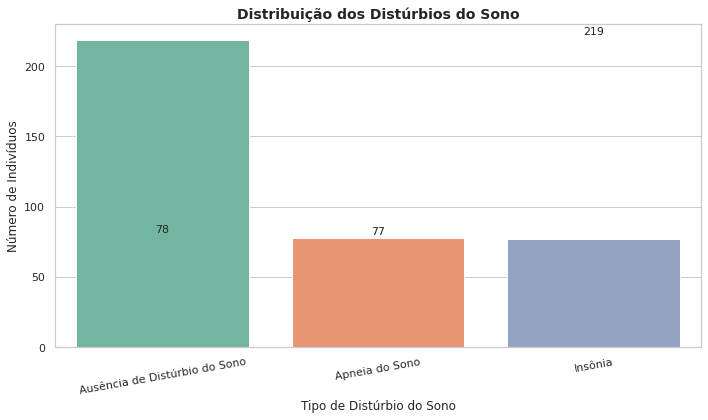

In [0]:
# Importar bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F

# Carregar a tabela Silver
df_silver = spark.table("silver_sleep_health")

# Traduzir os rótulos dos distúrbios (incluindo None)
df_pt = df_silver.withColumn(
    "disturbio_sono",
    F.when(F.col("sleep_disorder") == "Sleep Apnea", "Apneia do Sono")
     .when(F.col("sleep_disorder") == "Insomnia", "Insônia")
     .when(F.col("sleep_disorder") == "None", "Ausência de Distúrbio do Sono")
     .otherwise("Desconhecido")  # Segurança extra para casos inesperados
)

# Agrupar e converter para Pandas
sleep_disorder_counts = (
    df_pt.groupBy("disturbio_sono").count()
    .toPandas()
    .sort_values(by="count", ascending=False)
)

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(
    x="disturbio_sono",
    y="count",
    data=sleep_disorder_counts,
    palette="Set2"
)

# Adicionar valores no topo das barras
for i, row in sleep_disorder_counts.iterrows():
    ax.text(i, row["count"] + 2, f"{row['count']}", ha="center", va="bottom", fontsize=11)

# Título e rótulos
plt.title("Distribuição dos Distúrbios do Sono", fontsize=14, weight='bold')
plt.xlabel("Tipo de Distúrbio do Sono", fontsize=12)
plt.ylabel("Número de Indivíduos", fontsize=12)
plt.xticks(rotation=10, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

### Distribuição dos Distúrbios do Sono

O gráfico acima mostra a distribuição dos indivíduos conforme a presença (ou não) de distúrbios do sono.

- A maioria dos participantes **não apresenta distúrbios**, com cerca de **219 indivíduos (aproximadamente 58%)** classificados com “Ausência de Distúrbio do Sono”.
- Os demais estão quase igualmente divididos entre:
  - **Apneia do Sono**: 78 indivíduos (~21%)
  - **Insônia**: 77 indivíduos (~21%)

Essa distribuição mostra que cerca de **42% da amostra possui algum distúrbio do sono**, o que representa um percentual significativo. Apesar de o dataset ser sintético (gerado artificialmente), ele oferece uma amostra balanceada o suficiente para análises comparativas entre os grupos.

**Implicações práticas**: Para profissionais ou negócios da área da saúde (como clínicas do sono), esses dados indicam que quase metade da população avaliada poderia demandar algum tipo de intervenção ou tratamento. Como insônia e apneia aparecem em proporções semelhantes, estratégias de atenção e cuidado devem ser **equilibradas entre ambos os distúrbios**.

Na sequência, aprofundaremos a relação entre distúrbios, **qualidade** e **duração do sono**.

**Relação entre Duração do Sono, Qualidade e Distúrbios**

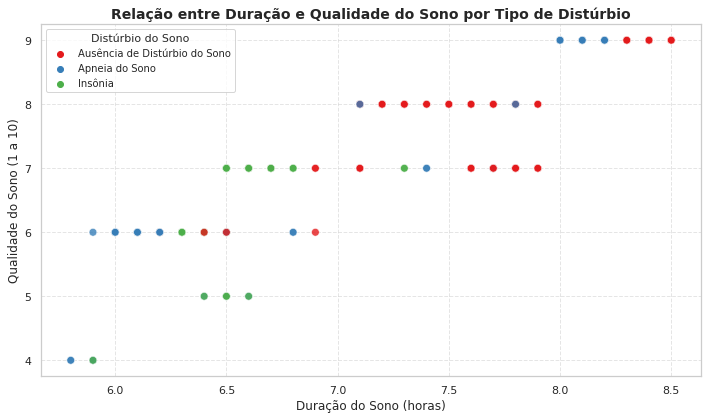

In [0]:
# Importar bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F

# Carregar a tabela Silver
df_silver = spark.table("silver_sleep_health")

# Traduzir os rótulos dos distúrbios (inclusive None)
df_plot = df_silver.select("sleep_duration", "sleep_quality", "sleep_disorder") \
    .withColumn(
        "disturbio_sono",
        F.when(F.col("sleep_disorder") == "Sleep Apnea", "Apneia do Sono")
         .when(F.col("sleep_disorder") == "Insomnia", "Insônia")
         .when(F.col("sleep_disorder") == "None", "Ausência de Distúrbio do Sono")
         .otherwise("Desconhecido")
    ).toPandas()

# Gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=df_plot,
                x="sleep_duration",
                y="sleep_quality",
                hue="disturbio_sono",
                palette="Set1",
                alpha=0.8,
                s=60)

plt.title("Relação entre Duração e Qualidade do Sono por Tipo de Distúrbio", fontsize=14, weight='bold')
plt.xlabel("Duração do Sono (horas)", fontsize=12)
plt.ylabel("Qualidade do Sono (1 a 10)", fontsize=12)
plt.legend(title="Distúrbio do Sono", fontsize=10, title_fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

O gráfico de dispersão acima relaciona horas de sono por noite (eixo X) com a qualidade do sono autoavaliada (eixo Y), e diferencia os indivíduos por categoria de distúrbio do sono. Observamos uma tendência clara: há uma correlação positiva entre dormir mais horas e ter uma qualidade de sono melhor. Os pontos se concentram aproximadamente em uma diagonal ascendente – ou seja, quem dorme pouco (em torno de 6 horas) tende a reportar qualidade menor (por volta de 5-6), enquanto quem dorme perto de 8 horas tende a dar notas de qualidade maiores (7-9).

Além disso, as cores/formatos dos pontos indicam que:
	•	Indivíduos com Insomnia (marcadores verdes “x”) estão predominantemente na parte inferior esquerda do gráfico – muitos dormem menos de 6.5 horas e avaliam a qualidade entre 4 e 7. Não surpreende, já que insônia se caracteriza por dificuldade em manter um sono longo e restaurador.
	•	Indivíduos com Sleep Apnea (azul) também sofrem impacto, embora um pouco menos extremo: muitos dormem entre ~6 e 7.5 horas com qualidade variando de 6 a 8. A apneia pode fragmentar o sono, reduzindo sua eficácia, o que explica por que mesmo com horas relativamente ok, a qualidade pode não ser máxima.
	•	Aqueles sem distúrbio (vermelho) se espalham mais para direita e topo: é mais comum vê-los dormindo 7-8+ horas e alcançando qualidade alta (7-9). Há poucos vermelhos em qualidade 5 ou 6.

Essa relação confirma o esperado: distúrbios prejudicam tanto a duração quanto a percepção de qualidade do sono. Para um negócio na área de saúde, reforça-se a importância de tratar problemas de sono não só para melhorar a quantidade de horas dormidas, mas também a qualidade percebida pelo paciente.

**Impacto do Estresse e Atividade Física**

A partir dos dados agregados e correlacionados, verificamos que o nível de estresse tem forte correlação negativa com o sono:
	•	Pessoas sem distúrbio apresentam estresse médio ~4.5, enquanto insones e apneicos têm ~7.1 e ~6.9 respectivamente (bem mais alto).
	•	A correlação Pearson entre stress_level e sleep_quality no dataset Silver é aproximadamente -0.90, e com sleep_duration cerca de -0.81, indicando que níveis altos de estresse estão associados a dormir menos e pior (o que faz sentido intuitivo e clínico).

Por outro lado, o nível de atividade física diário (minutos de exercício) não varia tanto entre os grupos de distúrbio (médias ~60 min para quem não tem distúrbio vs ~45 min com distúrbio). A correlação entre atividade física e qualidade do sono é positiva porém fraca (~0.19 no coeficiente de Pearson). Ou seja, praticar mais exercícios ajuda um pouco no sono, mas no dataset o efeito é modesto. Pode ser que todos tenham algum nível mínimo de atividade (ninguém sedentário absoluto) e poucos muito ativos, limitando a variabilidade.

Entretanto, a frequência cardíaca de repouso ficou mais alta em média para quem tem distúrbios (cerca de 80 bpm) comparado a quem não tem (73 bpm). Isso pode indicar que insônia e apneia estão associadas a pior condicionamento ou maior ativação do sistema cardiovascular (possivelmente relacionado ao estresse). Já a média de passos diários também foi bem menor nos grupos com distúrbio (~5000) versus sem (~7700), sugerindo que problemas de sono podem vir acompanhados de estilo de vida menos ativo (ou vice-versa, menos atividade pode prejudicar o sono).

**Diferenças por Ocupação e Gênero**

Analisando os dados por ocupação, encontramos insights interessantes:
	•	Profissionais de vendas parecem ter os piores indicadores de sono. Por exemplo, os Sales Representatives dormem em média apenas ~5.9 horas com qualidade média em torno de 4 (muito baixa) e figuram com os maiores níveis de estresse (~8 de média!). Essa ocupação pode envolver pressão por metas e horários irregulares, explicando o alto estresse e pouco sono. Outra categoria similar, Salesperson, também está entre as piores (média ~6.4h de sono, qualidade 6.0, estresse 7.0).
	•	Em contraste, ocupações de Engenharia apresentam os melhores resultados de sono. Os dados indicam que Engineers (genérico) dormem quase 8 horas (7.99h) em média, com qualidade acima de 8, e relatam o menor estresse (~3.9). Lawyers e Accountants também dormem bastante (7.4h e 7.1h) e têm qualidade alta (~7.9), possivelmente indicando rotinas mais controladas ou conscientização sobre saúde.
	•	Médicos (Doctors) e enfermeiros (Nurses) estão em posição intermediária, com ~7 horas de sono e qualidade ~7, mas curiosamente apresentam estresse relativamente elevado (especialmente médicos com média ~6.7 de estresse). Isso sugere que, embora consigam dormir uma quantidade decente, a tensão da profissão médica afeta a qualidade percebida (ainda assim melhor que a do pessoal de vendas).
	•	Professores (Teachers) e gestores (Managers) também mostraram métricas medianas (sono ~6.7-6.9h, qualidade ~7.0, estresse ~5.0), sem extremos.

Em resumo, profissões com maior estresse profissional tendem a refletir pior perfil de sono. Este achado pode ser valioso para programas de bem-estar corporativo: empresas de setores comerciais poderiam investir em apoio ao sono dos funcionários (por exemplo, gerenciamento de estresse, horários flexíveis), enquanto setores de engenharia aparentemente já demonstram equilíbrio melhor (mas não se deve ignorar indivíduos fora da média).

**Quanto às diferenças por gênero:**
	•	Mulheres no dataset dormem um pouco mais que homens (7.23 vs 7.04 horas em média) e relatam qualidade do sono superior (7.66 vs 6.97). Além disso, o nível médio de estresse das mulheres é menor (4.68 contra 6.08 dos homens).
	•	Essa tendência sugere que, nesta amostra, homens estão mais estressados e dormindo pior que mulheres. Poderia ser reflexo das ocupações (talvez mais homens em cargos de alta pressão?) ou outros fatores sociais. De qualquer forma, indica um possível público-alvo: homens poderiam demandar mais intervenções de saúde do sono.
	•	Não há diferença de gênero nos distúrbios presentes: tanto insônia quanto apneia apareceram em ambos gêneros, mas os efeitos parecem alinhados ao nível de estresse e hábitos de cada indivíduo.

**Resumo dos Insights Chave**
	•	Distúrbios do Sono são comuns: Quase 42% da amostra possui insônia ou apneia, impactando negativamente suas horas e qualidade de sono.
	•	Estresse é um fator crítico: Altos níveis de estresse se associam a sono insuficiente e insatisfatório. Programas para redução de estresse podem melhorar a saúde do sono.
	•	Atividade Física e Condicionamento: Embora todos façam alguma atividade, indivíduos com melhor sono tendem a dar mais passos diários e ter FC de repouso mais baixa (melhor condicionamento cardiovascular). Estímulo à atividade física pode trazer benefícios moderados ao sono.
	•	Ocupação influencia o sono: Profissionais de vendas destacam-se negativamente (alto estresse, pior sono), enquanto engenheiros e alguns profissionais liberais têm sono melhor. Empresas podem usar esses dados para direcionar ações de saúde ocupacional.
	•	Diferenças de Gênero: Homens da amostra tiveram piores resultados de sono que mulheres, possivelmente ligados a maiores níveis de estresse. Intervenções podem ser direcionadas levando isso em conta.

7. **Conclusão e Autoavaliação**_

Conclusão do Estudo: Construímos um pipeline completo de dados, passando pelas camadas Bronze (ingestão bruta), Silver (refinamento e limpeza) e Gold (agregação e sumarização), usando Spark no ambiente Databricks. O dataset Sleep Health and Lifestyle nos permitiu explorar como fatores de estilo de vida e saúde se relacionam com a qualidade do sono. Confirmamos expectativas, como o impacto negativo do estresse e de distúrbios como insônia, e levantamos insights acionáveis, como a identificação de grupos (por profissão ou gênero) que poderiam se beneficiar de atenção especial para melhoria do sono. Todos os passos foram documentados em detalhe, mostrando não apenas o o que foi feito, mas por que – desde decisões de modelagem até interpretação de resultados._

Aprendizados e Boas Práticas Aplicadas: Conseguimos aplicar com sucesso boas práticas de engenharia de dados, como a organização em camadas, o uso de formatos colunar eficientes (Parquet), a criação de um catálogo de dados, e transformações com APIs distribuídas do Spark ao invés de abordagens sequenciais. A separação em Bronze/Silver/Gold demonstrou como cada camada tem um propósito distinto (confiabilidade vs. usabilidade vs. valor de negócio). Além disso, integraremos no futuro a automação desses passos em um fluxo de trabalho repetível (por exemplo, usando jobs do Databricks ou pipelines de integração contínua de dados).